UNIVERSO DI GIOCO e simulazione cicli:

In [2]:
import random
import itertools
import numpy as np
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras import layers, models, Input
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate
import os
import json
import random
import signal
import sys
import statistics
import matplotlib.pyplot as plt

Implementazione genoma:

In [3]:
def hex_to_bin(hex_string):
    # Converti una stringa esadecimale in una stringa binaria di 32 bit
    return bin(int(hex_string, 16))[2:].zfill(32)

def interpret_gene(gene, num_input_neurons, num_hidden_neurons, num_output_neurons):
    bin_string = hex_to_bin(gene)
    
    # Dividi la stringa binaria nelle 5 sezioni
    source_type = int(bin_string[0])  # Input o interno (1 bit)
    source_id_bin = bin_string[1:8]  # Identificativo neurone sorgente (7 bit)
    target_type = int(bin_string[8])  # Output o interno (1 bit)
    target_id_bin = bin_string[9:16]  # Identificativo neurone destinazione (7 bit)
    weight_bin = bin_string[16:]  # Peso della connessione (16 bit, signed)
    
    # Calcola gli identificativi dei neuroni come valori unsigned modulo il numero di neuroni
    source_id = int(source_id_bin, 2) % (num_input_neurons if source_type == 0 else num_hidden_neurons)
    target_id = int(target_id_bin, 2) % (num_hidden_neurons if target_type == 0 else num_output_neurons)
    
    # Converti il peso in un numero intero con segno
    weight = int(weight_bin, 2)
    if weight >= 2**15:  # Converti in negativo se il bit più significativo è 1
        weight -= 2**16
    
    # Normalizza il peso
    weight_normalized = weight / 9000.0
    
    return (source_type, source_id, target_type, target_id, weight_normalized)

def interpret_genome(hex_genome, calls_input_neurons, calls_hidden_neurons, calls_output_neurons,
                     cards_input_neurons, cards_hidden_neurons, cards_output_neurons):
    genes = hex_genome.split()
    midpoint = len(genes) // 2
    calls_genes = genes[:midpoint]
    cards_genes = genes[midpoint:]
    
    calls_active_inputs = []
    cards_active_inputs = []

    calls_connections = []
    cards_connections = []

    for gene in calls_genes:
        source_type, source_id, target_type, target_id, weight = interpret_gene(gene, calls_input_neurons, calls_hidden_neurons, calls_output_neurons)
        calls_connections.append((source_type, source_id, target_type, target_id, weight))
        if source_type == 0:  # Source is input neuron
            calls_active_inputs.append(source_id)

    for gene in cards_genes:
        source_type, source_id, target_type, target_id, weight = interpret_gene(gene, cards_input_neurons, cards_hidden_neurons, cards_output_neurons)
        cards_connections.append((source_type, source_id, target_type, target_id, weight))
        if source_type == 0:  # Source is input neuron
            cards_active_inputs.append(source_id)

    return calls_connections, calls_active_inputs, cards_connections, cards_active_inputs

def create_genome(num_genes, calls_input_neurons, calls_hidden_neurons, calls_output_neurons,
                     cards_input_neurons, cards_hidden_neurons, cards_output_neurons):
    """
    Creates a genome consisting of a specified number of genes.
    Each gene is represented by an 8-character hexadecimal string,
    which encodes source and target neuron IDs and the connection weight.
    """
    genome = ""
    for _ in range(int(num_genes/2)):
        # Source neuron type (input or hidden) and ID
        source_type = np.random.choice(['0', '1'])
        source_id = np.random.randint(0, (calls_input_neurons if source_type == '0' else calls_hidden_neurons)-1)

        # Target neuron type (hidden or output) and ID
        target_type = np.random.choice(['0', '1'])
        target_id = np.random.randint(0, (calls_hidden_neurons if target_type == '0' else calls_output_neurons)-1)

        # Weight of the connection as a signed 16-bit integer
        weight = np.random.randint(-32768, 32768)

        # Convert each part to its binary representation
        source_id_bin = format(source_id, '07b')  # 7 bits for neuron ID
        target_id_bin = format(target_id, '07b')  # 7 bits for neuron ID
        weight_bin = format(weight & 0xFFFF, '016b')  # 16 bits for weight (2's complement)

        # Concatenate binary representations into one gene string
        gene_bin = f'{source_type}{source_id_bin}{target_type}{target_id_bin}{weight_bin}'

        # Convert the binary gene to hexadecimal
        gene_hex = format(int(gene_bin, 2), '08X')
        genome = genome+" "+str(gene_hex)

    for _ in range(int(num_genes/2)):
        # Source neuron type (input or hidden) and ID
        source_type = np.random.choice(['0', '1'])
        source_id = np.random.randint(0, (cards_input_neurons if source_type == '0' else cards_hidden_neurons)-1)

        # Target neuron type (hidden or output) and ID
        target_type = np.random.choice(['0', '1'])
        target_id = np.random.randint(0, (cards_hidden_neurons if target_type == '0' else cards_output_neurons)-1)

        # Weight of the connection as a signed 16-bit integer
        weight = np.random.randint(-32768, 32768)

        # Convert each part to its binary representation
        source_id_bin = format(source_id, '07b')  # 7 bits for neuron ID
        target_id_bin = format(target_id, '07b')  # 7 bits for neuron ID
        weight_bin = format(weight & 0xFFFF, '016b')  # 16 bits for weight (2's complement)

        # Concatenate binary representations into one gene string
        gene_bin = f'{source_type}{source_id_bin}{target_type}{target_id_bin}{weight_bin}'

        # Convert the binary gene to hexadecimal
        gene_hex = format(int(gene_bin, 2), '08X')
        genome = genome+" "+str(gene_hex)
    
    return genome

def mutate(hex_genome, calls_input_neurons, calls_hidden_neurons, calls_output_neurons,
           cards_input_neurons, cards_hidden_neurons, cards_output_neurons, mutation_rate=0.005):
    """
    Mutates the given genome with the provided mutation rate. Different parts of the genome
    are treated with different neuron limits depending on their function (calls vs cards).
    """
    genes = hex_genome.split()
    midpoint = len(genes) // 2
    calls_genes = genes[:midpoint]
    cards_genes = genes[midpoint:]
    mutated_genes = []

    # Mutate the 'calls' genes
    for gene in calls_genes:
        mutated_genes.append(mutate_gene(gene, calls_input_neurons, calls_hidden_neurons, calls_output_neurons, mutation_rate))

    # Mutate the 'cards' genes
    for gene in cards_genes:
        mutated_genes.append(mutate_gene(gene, cards_input_neurons, cards_hidden_neurons, cards_output_neurons, mutation_rate))

    return ' '.join(mutated_genes)

def mutate_gene(gene, num_input_neurons, num_hidden_neurons, num_output_neurons, mutation_rate):
    # Convert gene to binary
    binary = hex_to_bin(gene)

    # Define sections of the gene
    source_type = int(binary[0])
    source_id = int(binary[1:8], 2)
    target_type = int(binary[8])
    target_id = int(binary[9:16], 2)
    weight = binary[16:]

    # Mutate source_id
    if np.random.rand() < mutation_rate:
        # Create a random index within valid range
        source_id = np.random.randint(0, (num_input_neurons if source_type == 0 else num_hidden_neurons)-1)
    
    # Mutate target_id
    if np.random.rand() < mutation_rate:
        # Create a random index within valid range
        target_id = np.random.randint(0, (num_hidden_neurons if target_type == 0 else num_output_neurons)-1)
    
    # Mutate weight
    weight = list(weight)
    for i in range(len(weight)):
        if np.random.rand() < mutation_rate:
            weight[i] = '1' if weight[i] == '0' else '0'
    weight = ''.join(weight)

    # Convert back to binary and then to hex
    mutated_gene = f"{source_type}{format(source_id, '07b')}{target_type}{format(target_id, '07b')}{weight}"
    mutated_hex = format(int(mutated_gene, 2), '08X')
    return mutated_hex

Estensione alle reti neurali:

In [4]:
def card_to_index(card):
    if card == None:
        return -1
    suit_map = {'Denari': 0, 'Coppe': 1, 'Spade': 2, 'Bastoni': 3}
    value_map = {i: i-1 for i in range(1, 11)}
    suit, value = card
    suit_index = suit_map[suit]
    value_index = value_map[value]
    return suit_index * len(value_map) + value_index

def cards_to_indices(hand, max_cards=5, pad_value=-1):
    indices = [card_to_index(card) for card in hand]
    # Applica padding per riempire fino a max_cards
    padded_indices = indices + [pad_value] * (max_cards - len(indices))
    return np.array(padded_indices)

In [10]:
calls_additional_features = 4  # Numero di input aggiuntivi
calls_input_neurons = calls_additional_features + 5
calls_hidden_neurons = 5
calls_output_neurons = 6

cards_additional_features = 6  # Numero di input aggiuntivi
cards_input_neurons = calls_additional_features + 5
cards_hidden_neurons = 10
cards_output_neurons = 5

class Neuron:
    def __init__(self):
        self.incoming = []  # Connessioni in entrata
        self.outgoing = []  # Connessioni in uscita
        self.output = 0     # Output del neurone, inizializzato a 0

class Connection:
    def __init__(self, source, target, weight):
        self.source = source
        self.target = target
        self.weight = weight

class DynamicNetwork:
    def __init__(self, num_input, num_hidden, num_output):
        self.input_neurons = [Neuron() for _ in range(num_input)]
        self.hidden_neurons = [Neuron() for _ in range(num_hidden)]
        self.output_neurons = [Neuron() for _ in range(num_output)]
        self.active_input_indices = []

    def add_connection(self, source_neuron, target_neuron, weight):
        connection = Connection(source_neuron, target_neuron, weight)
        source_neuron.outgoing.append(connection)
        target_neuron.incoming.append(connection)
        # Se la source è un neurone di input, marcala come attiva
        if source_neuron in self.input_neurons:
            index = self.input_neurons.index(source_neuron)
            if index not in self.active_input_indices:
                self.active_input_indices.append(index)
                
    def forward_pass(self, inputs):
        # Assumi che gli input siano assegnati ai neuroni di input
        for i, input_value in enumerate(inputs):
            if i < len(self.input_neurons):
                self.input_neurons[i].output = input_value

        # Calcola l'output per i neuroni nascosti e di output
        for layer in [self.hidden_neurons, self.output_neurons]:
            for neuron in layer:
                total_input = sum(conn.weight * conn.source.output for conn in neuron.incoming)
                neuron.output = self.activate(total_input)  # Attiva usando una funzione di attivazione, es. sigmoid

        return [neuron.output for neuron in self.output_neurons]

    def activate(self, x):
        # Funzione di attivazione sigmoid
        return 1 / (1 + np.exp(-x))

    def predict(self, inputs):
        # Preparazione degli input
        input_values = inputs[0]  # Assumiamo che il primo elemento di inputs sia l'array per i neuroni di input
        return self.forward_pass(input_values)

class Player:
    def __init__(self, player_id, genome, hand=[], calls_hidden_neurons = calls_hidden_neurons, cards_hidden_neurons = cards_hidden_neurons,
                 calls_output_neurons = calls_output_neurons, cards_output_neurons = cards_output_neurons, calls_input_neurons = calls_input_neurons, cards_input_neurons = cards_input_neurons):
        self.player_id = player_id
        self.hand = hand
        self.prediction = 0
        self.genome = genome
        self.tricks_won = 0  # Aggiungiamo un contatore per le prese vinte
        self.lives = 0
        self.startingHand = hand
        self.calls_connections, self.calls_actives, self.cards_connections, self.cards_actives = interpret_genome(genome, calls_input_neurons, calls_hidden_neurons, calls_output_neurons, cards_input_neurons, cards_hidden_neurons, cards_output_neurons)
        self.call_model = DynamicNetwork(calls_input_neurons, calls_hidden_neurons, calls_output_neurons)
        self.cards_model = DynamicNetwork(cards_input_neurons, cards_hidden_neurons, cards_output_neurons)
        self.initialize_networks()
    
    def select_card(self, winning_card, total_preds, players, remaining_preds, remaining_players):
    # Numero massimo di carte che possono essere scelte (il numero di carte in mano)
        if not self.hand:
            return None
        input_cards = cards_to_indices(self.hand, max_cards=5, pad_value=-1)
        input_winning_card = card_to_index(winning_card)
        max_cards = len(self.hand)

        # Include dati aggiuntivi
        full_input = np.concatenate([input_cards, [input_winning_card, total_preds, players, max_cards, remaining_preds, remaining_players]])
        decision = self.cards_model.predict(np.array([full_input]))  # Assicurati che l'input sia bidimensionale
        selected_card = self.hand[np.argmax(decision)]

        #selected_card = random.choice(self.hand)
        self.hand.remove(selected_card)
        return selected_card
    
    def initialize_networks(self):
        # Initialize networks using the pre-interpreted connections
        for connection in self.calls_connections:
            source_type, source_id, target_type, target_id, weight = connection
            source_neuron = self.get_neuron(self.call_model, source_type, source_id)
            target_neuron = self.get_neuron(self.call_model, target_type, target_id)
            self.call_model.add_connection(source_neuron, target_neuron, weight)

        for connection in self.cards_connections:
            source_type, source_id, target_type, target_id, weight = connection
            source_neuron = self.get_neuron(self.cards_model, source_type, source_id)
            target_neuron = self.get_neuron(self.cards_model, target_type, target_id)
            self.cards_model.add_connection(source_neuron, target_neuron, weight)

    def get_neuron(self, network, neuron_type, neuron_id):
        # Returns the neuron if the ID is within the valid range, otherwise logs an error and returns None
        if neuron_type == 0:
            if neuron_id < len(network.input_neurons):
                return network.input_neurons[neuron_id]
        elif neuron_type == 1:
            if neuron_id < len(network.hidden_neurons):
                return network.hidden_neurons[neuron_id]
        elif neuron_type == 2:
            if neuron_id < len(network.output_neurons):
                return network.output_neurons[neuron_id]

        print(f"Error: Neuron index out of range. Neuron type: {neuron_type}, Neuron ID: {neuron_id}")
        return None  # Return None if the neuron ID is out of range

    def make_prediction(self, num_cards, num_players, total_predictions, remaining_players):
        input_cards = cards_to_indices(self.hand, max_cards=5, pad_value=-1)
        # Include dati aggiuntivi
        full_input = np.concatenate([input_cards, [num_cards, num_players, total_predictions, remaining_players]])
        decision = self.call_model.predict(np.array([full_input]))  # Assicurati che l'input sia bidimensionale
        self.prediction = np.argmax(decision)

class CardGame:
    def __init__(self, selected_players):
        self.num_players = len(selected_players)
        self.players = selected_players
        self.current_starter = 0
        self.suits = ['Bastoni', 'Spade', 'Coppe', 'Denari']
        self.suit_values = {'Bastoni': 1, 'Spade': 2, 'Coppe': 3, 'Denari': 4}
        self.values = range(1, 11)
        self.deck = self.create_deck()
        self.calls = 0
    
    def create_deck(self):
        return list(itertools.product(self.suits, self.values))

    def play_round(self, num_cards):
        self.deal_cards(num_cards)
        tot_preds = self.make_predictions(num_cards)
        for _ in range(len(self.players[0].hand)):
            tricks = self.play_hand(tot_preds, num_cards, _)
            # Aggiorna il vincitore della mano come nuovo starter
            self.current_starter = tricks['winner']
            self.players[self.current_starter].tricks_won += 1  # Aggiungi la presa al vincitore
        self.update_lives()
    
    def update_lives(self):
        #print("Stato attuale delle vite dei giocatori:")
        for player_id, player in enumerate(self.players):
            difference = abs(player.tricks_won - player.prediction)
            player.lives -= difference  # Assumendo che ogni giocatore inizi con un certo numero di vite
            #print(f"Giocatore {player_id}: {difference} vite perse in questa mano, {player.lives} in totale. _________ Dichiarate: {player.prediction}. Vinte: {player.tricks_won}. Carte a disposizione: {player.startingHand}")
            player.prediction = 0  # Reset delle previsioni se necessario
            player.tricks_won = 0

    def play_hand(self, tot_preds, num_cards, _):
        tricks = {'cards': [], 'winner': None, 'winning_card': None}
        #print(f"\nInizio della mano {_+1} da {num_cards} carte:")
        for i in range(self.num_players):
            player_id = (self.current_starter + i) % self.num_players

            # Calcola le prese rimanenti per i giocatori successivi
            if i < self.num_players - 1:
                preds_after_current = sum(p.prediction for p in self.players[player_id + 1:])
                won_after_current = sum(p.tricks_won for p in self.players[player_id + 1:])
                remaining_preds = preds_after_current - won_after_current
            else:
                remaining_preds = 0  # Nessun giocatore successivo

            card = self.players[player_id].select_card(tricks["winning_card"], tot_preds, self.num_players, remaining_preds, self.num_players-1-i)
            # Aggiungiamo una stampa per mostrare quale giocatore gioca quale carta
            #print(f"Giocatore {player_id} gioca la carta {card}")
            tricks['cards'].append((player_id, card))
        
        # Determina il vincitore della mano
        winning_card = None
        winning_player = None
        for player_id, card in tricks['cards']:
            if winning_card is None or self.compare_cards(card, winning_card):
                winning_card = card
                winning_player = player_id
        
        # Stampa il vincitore della mano e la carta vincente
        #print(f"Vincitore della mano: Giocatore {winning_player} con la carta {winning_card}\n")
        tricks['winner'] = winning_player
        tricks['winning_card'] = winning_card
        
        return tricks

    def compare_cards(self, card1, card2):
        # Confronta due carte e ritorna True se card1 è maggiore di card2
        suit1_value = self.suit_values[card1[0]]
        suit2_value = self.suit_values[card2[0]]
        if suit1_value > suit2_value:
            return True
        elif suit1_value == suit2_value:
            return card1[1] > card2[1]
        return False
    
    def start_game(self, cycles):
        max_cards = 5  # Numero massimo di carte
        for _ in range(cycles):  # Esegue il numero di cicli specificato
            for num_cards in range(max_cards, 0, -1):  # Da 5 a 1 carta
                self.play_round(num_cards)
            # Opcionalmente, puoi controllare le vite qui per decidere se continuare
            # Ma per ora, il gioco esegue semplicemente tutti i cicli
            #print(f"Ciclo completato. Vite finali:")
            #for player_id, player in enumerate(self.players):
            #    print(f"Giocatore {player_id}: {player.lives} vite perse.")
            # Qui potresti inserire una logica per terminare il gioco in base alle vite rimaste
            # o semplicemente procedere al ciclo successivo

    def deal_cards(self, num_cards):
        self.deck = self.create_deck()  # Ricrea il mazzo per ogni nuova partita
        random.shuffle(self.deck)
        for player in self.players:
            player.hand = [self.deck.pop() for _ in range(num_cards)]
            player.startingHand = player.hand.copy()
        #print("\nINIZIO MANO: \nCarte distribuite.")

    def make_predictions(self, num_cards):
        total_predictions = 0
        remaining_players = self.num_players - 1
        for player_id, player in enumerate(self.players[:-1]):  # Cicla su tutti i giocatori tranne l'ultimo
            player.make_prediction(num_cards, self.num_players, total_predictions, remaining_players)
            #print(f"Giocatore {player_id} dichiara {player.prediction} prese.")
            self.calls += player.prediction
            total_predictions = self.calls
            remaining_players -= 1
        # Gestisce la chiamata per l'ultimo giocatore
        last_player = self.players[-1]
        last_player.make_prediction(num_cards, self.num_players, total_predictions, remaining_players)
        # Assicurati che la somma totale delle chiamate non sia uguale al numero di carte in mano
        if total_predictions + last_player.prediction == num_cards:
            # Se la condizione non è soddisfatta, modifica la chiamata dell'ultimo giocatore
            possible_predictions = [i for i in range(0, len(last_player.hand) + 1)
                                    if total_predictions + i != len(last_player.startingHand)]
            last_player.prediction = random.choice(possible_predictions)
        #print(f"Giocatore {last_player.player_id} dichiara {last_player.prediction} prese.")
            # modifica questo punto facendo scegliere al giocatore se aggiungere o togliere una presa dalla chiamata iniziale
        return total_predictions

In [58]:
def default_converter(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

def save_generation(players, generation_number):
    path = f"C:\\Users\\giaco\\Desktop\\Projects\\BISCHE\\generations_backup\\generation_{generation_number}.txt"
    data = {
        "generation": generation_number,
        "players": []
    }

    # Estrai i genomi dai giocatori per calcolare la distanza di Hamming
    genomes = [player.genome for player in players]
    if len(genomes) > 1:
        hamming_mean_distance = average_hamming_distance(genomes)
    else:
        hamming_mean_distance = 0  # Non è possibile calcolare la distanza con un solo genoma

    data["hamming_mean_distance"] = hamming_mean_distance

    for player in players:
        player_data = {
            "player_id": player.player_id,
            "lives_lost": player.lives,
            "genome": player.genome
        }
        data["players"].append(player_data)
    
    with open(path, "w") as file:
        json.dump(data, file, indent=4, default=default_converter)

def select_top_players(players, percentile=75):
    """Seleziona il top 25% dei giocatori basato sulle vite perse."""
    players.sort(key=lambda x: -x.lives)
    top_count = int(len(players) * (percentile / 100))
    return players[:top_count]

def reproduce(players, num_players):
    """Crea una nuova generazione di giocatori usando i genomi dei migliori."""
    top_genomes = [player.genome for player in players]
    new_players = []
    for i in range(num_players):
        # Randomly pick a genome from the top players
        chosen_genome = random.choice(top_genomes)
        resulting_genome = mutate(chosen_genome, calls_input_neurons, calls_hidden_neurons, calls_output_neurons,
           cards_input_neurons, cards_hidden_neurons, cards_output_neurons, mutation_rate=0.001)
        new_player = Player(player_id=i, genome=resulting_genome)
        new_players.append(new_player)
    return new_players

def handle_signal(signum, frame):
    print("Interrompo il processo...")
    sys.exit(0)

def load_top_genomes(generation_number):
    path = f"C:\\Users\\giaco\\Desktop\\Projects\\BISCHE\\generations_backup\\generation_{generation_number}.txt"
    try:
        with open(path, "r") as file:
            data = json.load(file)
            # Ordina i giocatori in base alle vite perse (minore è meglio) e seleziona il top 20%
            top_players_data = sorted(data["players"], key=lambda x: -x["lives_lost"])[:len(data["players"]) // 5]
            top_genomes = [player["genome"] for player in top_players_data]
            return top_genomes
    except FileNotFoundError:
        print(f"File {path} non trovato. Inizio con genomi nuovi.")
        return []

def hamming_distance(s1, s2):
    """Calcola la distanza di Hamming tra due stringhe."""
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

def average_hamming_distance(genomes):
    """Calcola la distanza di Hamming media tra una lista di genomi."""
    num_genomes = len(genomes)
    total_distance = 0
    comparisons = 0
    
    for i in range(num_genomes):
        for j in range(i + 1, num_genomes):
            total_distance += hamming_distance(genomes[i], genomes[j])
            comparisons += 1
    
    return total_distance / comparisons if comparisons > 0 else 0

def load_genomes_from_file(generation_number):
    path = "C:\\Users\\giaco\\Desktop\\Projects\\BISCHE\\generations_backup\\generation_{}.txt".format(generation_number)
    with open(path, 'r') as file:
        data = json.load(file)
        genomes = [player['genome'] for player in data['players']]
    return genomes

def load_hamming_from_file(generation_number):
    path = "C:\\Users\\giaco\\Desktop\\Projects\\BISCHE\\generations_backup\\generation_{}.txt".format(generation_number)
    with open(path, 'r') as file:
        data = json.load(file)
    return data["hamming_mean_distance"]

def plot_hamming_distances(average_hammings):
    generations = list(range(1, len(average_hammings) + 1))  # Generazioni partendo da 1
    plt.figure(figsize=(10, 5))  # Imposta la dimensione del grafico
    plt.plot(generations, average_hammings, marker='o', linestyle='-', color='b')
    plt.title('Distanza Media di Hamming per Generazione')
    plt.xlabel('Numero di Generazione')
    plt.ylabel('Distanza Media di Hamming')
    plt.grid(True)  # Aggiungi una griglia per facilitare la lettura
    plt.show()

def evolutionary_cycle(num_players, num_genes, game_cycles):
    signal.signal(signal.SIGINT, handle_signal)
    signal.signal(signal.SIGTERM, handle_signal)
    current_generation = 1

    if os.path.exists("current_generation.txt"):
        with open("current_generation.txt", "r") as file:
            current_generation = int(file.read().strip())

    if current_generation > 1:
        top_genomes = load_top_genomes(current_generation - 1)
        all_players = [Player(player_id=i, genome=mutate(random.choice(top_genomes), calls_input_neurons, calls_hidden_neurons, calls_output_neurons,
           cards_input_neurons, cards_hidden_neurons, cards_output_neurons, mutation_rate=0.0055)) for i in range(num_players)]
    else:
        all_players = [Player(player_id=i, genome=create_genome(num_genes, calls_input_neurons, calls_hidden_neurons, calls_output_neurons, cards_input_neurons, cards_hidden_neurons, cards_output_neurons)) for i in range(num_players)]
    

    while True:
        print(f"Inizio della generazione {current_generation} con {game_cycles} cicli di gioco.")
        for i in range(game_cycles):
            if i % 2500 == 0:
                print(f"Ciclo {i+1} di {game_cycles} nella generazione {current_generation}")
            chosen_players = random.sample(all_players, random.randint(2, 8))
            game = CardGame(chosen_players)
            game.start_game(1)

        top_players = select_top_players(all_players, percentile=20)
        lives_lost_top = [player.lives for player in top_players]
        lives_lost_all = [player.lives for player in all_players]

        save_generation(all_players, current_generation)
        all_players = reproduce(top_players, num_players)

        mean_lives_lost_top = sum(lives_lost_top)
        variance_lives_lost_top = statistics.variance(lives_lost_top)

        print(f"Risultati della generazione {current_generation}:")
        print(f"Media delle vite perse dai top players: {mean_lives_lost_top:.2f}")
        print(f"Varianza delle vite perse dai top players: {variance_lives_lost_top:.2f}")

        mean_lives_lost_all = sum(lives_lost_all)
        variance_lives_lost_all = statistics.variance(lives_lost_all)

        print(f"Media generale delle vite perse: {mean_lives_lost_all:.2f}")
        print(f"Varianza generale delle vite perse: {variance_lives_lost_all:.2f}")

        current_generation += 1
        with open("current_generation.txt", "w") as file:
            file.write(str(current_generation))
        print("Riproduzione e mutazione dei genomi migliori...")

In [61]:
num_players = 200
num_genes = 64
game_cycles = 10000
evolutionary_cycle(num_players, num_genes, game_cycles)

Inizio della generazione 673 con 10000 cicli di gioco.
Ciclo 1 di 10000 nella generazione 673
Ciclo 2501 di 10000 nella generazione 673
Ciclo 5001 di 10000 nella generazione 673
Ciclo 7501 di 10000 nella generazione 673
Risultati della generazione 673:
Media delle vite perse dai top players: -26998.00
Varianza delle vite perse dai top players: 858.00
Media generale delle vite perse: -150000.00
Varianza generale delle vite perse: 3006.00
Riproduzione e mutazione dei genomi migliori...
Inizio della generazione 674 con 10000 cicli di gioco.
Ciclo 1 di 10000 nella generazione 674
Ciclo 2501 di 10000 nella generazione 674
Ciclo 5001 di 10000 nella generazione 674
Ciclo 7501 di 10000 nella generazione 674
Risultati della generazione 674:
Media delle vite perse dai top players: -26980.00
Varianza delle vite perse dai top players: 724.00
Media generale delle vite perse: -150000.00
Varianza generale delle vite perse: 3205.00
Riproduzione e mutazione dei genomi migliori...
Inizio della generazio

SystemExit: 0

In [130]:
# Example usage:
num_genes = 16  # Number of genes you want in the genome
num_input_neurons = 10
num_hidden_neurons = 20
num_output_neurons = 10

# Create a sample genome
hex_genome = create_genome(num_genes, num_input_neurons, 
                              num_hidden_neurons, num_output_neurons)
print("genoma creato: \n", hex_genome)
connections = interpret_genome(hex_genome, num_input_neurons, num_hidden_neurons, num_output_neurons)

# Stampa i dettagli delle connessioni
print("significato dei geni: ")
for conn in connections:
    print(f"Origine: {'Input' if conn[0] == 0 else 'Interno'}, ID Origine: {conn[1]}, "
          f"Destinazione: {'Interno' if conn[2] == 0 else 'Output'}, ID Destinazione: {conn[3]}, "
          f"Peso: {conn[4]}")
    
# Example usage:
mutation_rate = 0.01  # 1% chance of mutation per bit
mutated_genome = mutate(hex_genome, mutation_rate)
print("Original Genome: \n", hex_genome)
print("Mutated Genome: \n", mutated_genome)

connections = interpret_genome(mutated_genome, num_input_neurons, num_hidden_neurons, num_output_neurons)

# Stampa i dettagli delle connessioni
print("significato dei geni: ")
for conn in connections:
    print(f"Origine: {'Input' if conn[0] == 0 else 'Interno'}, ID Origine: {conn[1]}, "
          f"Destinazione: {'Interno' if conn[2] == 0 else 'Output'}, ID Destinazione: {conn[3]}, "
          f"Peso: {conn[4]}")
    


genoma creato: 
  9189C415 931363AD 831204E6 030F8D4E 8287D87D 8C80D731 05877021 06820B01 81014464 920443DC 8301CE6C 01071359 0113B22F 910EF949 060A20E6 020FA974
significato dei geni: 
Origine: Interno, ID Origine: 17, Destinazione: Output, ID Destinazione: 9, Peso: -1.7043333333333333
Origine: Interno, ID Origine: 19, Destinazione: Interno, ID Destinazione: 19, Peso: 2.8352222222222223
Origine: Interno, ID Origine: 3, Destinazione: Interno, ID Destinazione: 18, Peso: 0.13933333333333334
Origine: Input, ID Origine: 3, Destinazione: Interno, ID Destinazione: 15, Peso: -3.2624444444444443
Origine: Interno, ID Origine: 2, Destinazione: Output, ID Destinazione: 7, Peso: -1.123888888888889
Origine: Interno, ID Origine: 12, Destinazione: Output, ID Destinazione: 0, Peso: -1.1607777777777777
Origine: Input, ID Origine: 5, Destinazione: Output, ID Destinazione: 7, Peso: 3.1894444444444443
Origine: Input, ID Origine: 6, Destinazione: Output, ID Destinazione: 2, Peso: 0.313
Origine: Interno, ID 

analisi biodiversità

100 / 1500
200 / 1500
300 / 1500
400 / 1500
500 / 1500
600 / 1500
700 / 1500
800 / 1500
900 / 1500
1000 / 1500
1100 / 1500
1200 / 1500
1300 / 1500
1400 / 1500


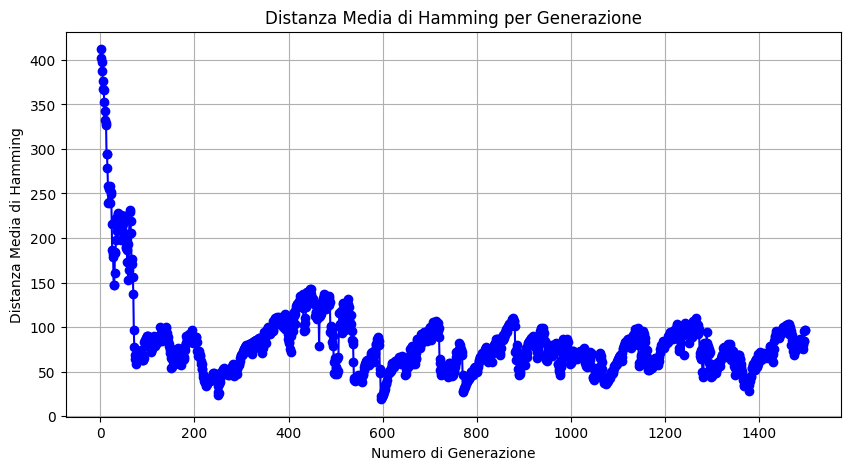

In [62]:
average_hammings = []
generation_number = 1  # Numero della generazione da analizzare

current_generation = 1

if os.path.exists("current_generation.txt"):
    with open("current_generation.txt", "r") as file:
        current_generation = int(file.read().strip())

for i in range(1, current_generation):
    mean_hamming_dist = load_hamming_from_file(i)
    average_hammings.append(mean_hamming_dist)
    if i % 100 == 0:
        print(i, '/', current_generation)
    #print(f"La distanza di Hamming media per la generazione {generation_number} è {mean_hamming_dist:.2f}")

plot_hamming_distances(average_hammings)